In [1]:
import tensorflow as tf
import gym
from IPython.display import clear_output
import time
import numpy as np

In [2]:
env=gym.make('Skiing-v0')
obs=env.reset()

In [3]:
action=env.action_space.sample()
step=env.step(action)

In [4]:
model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(input_shape=(250,160,3),kernel_size=(3,3),filters=16),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32),
        #tf.keras.layers.MaxPool2D(strides=(2,2)),
        #tf.keras.layers.Conv2D(kernel_size=(3,3),filters=64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32,activation='relu'),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 158, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 79, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 77, 32)       4640      
_________________________________________________________________
flatten (Flatten)            (None, 300608)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                9619488   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [5]:
scores=[]
train_datas=[]
accepted_scores=[]

In [6]:
print(f'action space > {env.action_space}')
print(f'action > {action}')
print(env.observation_space.shape)
print(f'step > {step}')
#print(f'obs_space > {env.observation_space}')
#print(f'obs_space > {env.observation_space.high}')
#print(f'obs_space > {env.observation_space.low}')

action space > Discrete(3)
action > 2
(250, 160, 3)
step > (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), -3.0, False, {'ale.lives': 0})


In [7]:

required_score=-150000
eps=50
for i in range(eps):
    
    step=0
    score=0
    env.reset()    
    game_memory=[]
    prev_obs=[]
    for j in range(1000):
        action=env.action_space.sample()
        obs,reward,done,info=env.step(action)
        reward+=5
        ###########################################
        #reward=0
        #############################################
        #env.render()
        #clear_output(wait=False)
        #print(f'state> {obs}\nreward >{reward}\naction > {action}\n info >{info}')
        
        if len(prev_obs)>0:
            game_memory.append([prev_obs,action])
        prev_obs=obs
        
        step+=1
        score+=reward
        #if j%100==0:
        #    print(f'epoches >{i}\tstep> {step}\tscore >{score}')            
        if done:
            break;
    print(score)

    scores.append(score)
    if score>required_score :
        accepted_scores.append(score)
        for data in game_memory:
            train_datas.append(data)
print(type(scores))
scores=np.array(scores)
print(type(scores))
print(scores.mean())

34.0
3.0
41.0
36.0
74.0
19.0
43.0
-85.0
63.0
18.0
-45.0
14.0
54.0
36.0
51.0
46.0
31.0
-19.0
38.0
8.0
21.0
39.0
58.0
4.0
-42.0
43.0
39.0
-6.0
-65.0
19.0
3.0
-7.0
-35.0
-35.0
43.0
-47.0
18.0
39.0
-12.0
-70.0
18.0
19.0
-34.0
16.0
53.0
-14.0
1.0
63.0
13.0
-25.0
<class 'list'>
<class 'numpy.ndarray'>
11.54


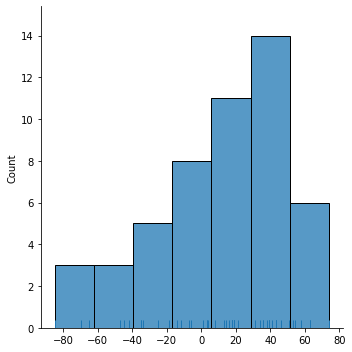

In [8]:
import seaborn as sns
sns.displot(scores,rug=True)

In [9]:
print(train_datas[:5])

[[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0], [array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [10]:
train_datas=train_datas[:5000]
train_x=np.array([i[0] for i in train_datas])
print(type(train_x))
train_y=np.array([i[1] for i in train_datas])
print(type(train_y))

#####################
#train_x=train_x[:5000,-1,-1,-1]
#train_y=train_y[:5000,-1]
############3

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
print(train_x.shape)
train_y=train_y.reshape(-1,1)
print(train_y.shape)

(5000, 250, 160, 3)
(5000, 1)


In [12]:
history=model.fit(train_x,train_y,epochs=7,batch_size=16, validation_split=0.25)

Epoch 1/7
235/235 [==============================] - 62s 263ms/step - loss: 168.3387 - accuracy: 0.3312 - val_loss: 1.0988 - val_accuracy: 0.3288
Epoch 2/7
235/235 [==============================] - 62s 262ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.0988 - val_accuracy: 0.3288
Epoch 3/7
235/235 [==============================] - 62s 264ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.0988 - val_accuracy: 0.3288
Epoch 4/7
235/235 [==============================] - 62s 263ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.0988 - val_accuracy: 0.3288
Epoch 5/7
235/235 [==============================] - 62s 265ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.0988 - val_accuracy: 0.3288
Epoch 6/7
235/235 [==============================] - 61s 261ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.0988 - val_accuracy: 0.3288
Epoch 7/7
235/235 [==============================] - 62s 265ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.0988 - val_accurac

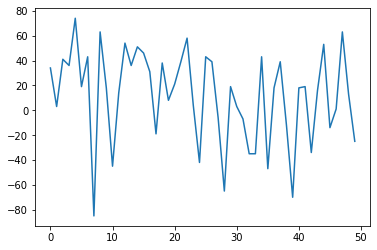

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(scores)
plt.show()

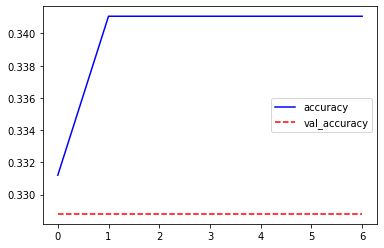

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.plot(history.history['val_accuracy'],'r--',label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
scores=[]
steps=[]
actions=[]

for i in range(5):
    obs=env.reset()
    score=0
    step=0
    for j in range(env._max_episode_steps):
        logit=model.predict(np.expand_dims(obs,axis=0))[0]
        
        print(logit)
        action=np.argmax(logit)
        obs,reward,done,info=env.step(action)
        env.render()
        time.sleep(0.013)
        score+=reward
        step=j
        if done :
            break
    print('epoch done')
    scores.append(score)
    steps.append(step)

In [ ]:

plt.plot(scores)
plt.show()